[*********************100%***********************]  5 of 5 completed


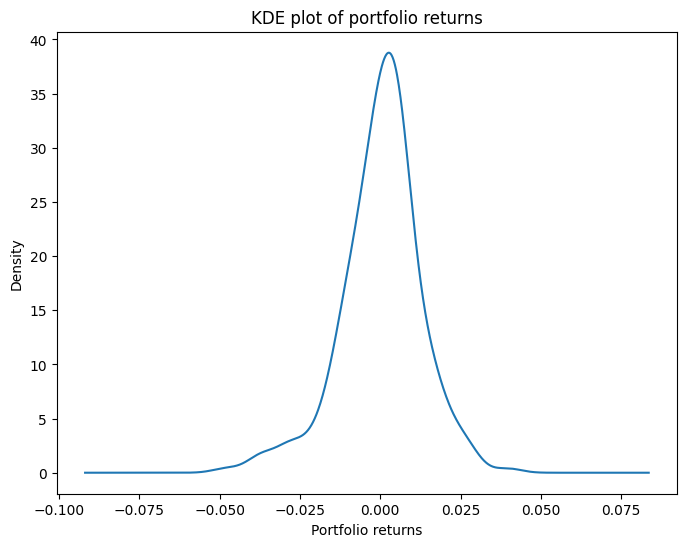

In [64]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

# Get data
start = '2016-01-01'
end = '2016-12-31'
etfs = ['AAPL', 'GOOG', 'MSFT', 'INTC', 'BOX']

data = yf.download(tickers=etfs, start=start, end=end)['Close']

# returns
ret_data = np.log(data / data.shift(1)).dropna()

# portfolio returns
weights = np.array([1/ret_data.shape[1]] * ret_data.shape[1])
port_data = pd.DataFrame(np.dot(ret_data, weights), index=ret_data.index, columns=['Portfolio.ret'])

# plot
plt.figure(figsize=(8, 6))
port_data['Portfolio.ret'].plot(kind='density')
plt.title('KDE plot of portfolio returns')
plt.xlabel('Portfolio returns')
plt.show()

In [65]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def calculate_var_and_cvar(ret_data, port_data, weights, alpha=0.01, num_simulations=1000):
    # Variance-Covariance VaR
    est_ret_vector = ret_data.mean().values
    est_cov_matrix = ret_data.cov().values
    est_sd_port = np.sqrt(np.dot(weights.T, np.dot(est_cov_matrix, weights)))
    VaR_var_covar = (est_sd_port * norm.ppf(alpha)) + port_data['Portfolio.ret'].mean()

    # Historical VaR
    VaR_hist_sim = port_data['Portfolio.ret'].sample(n=num_simulations, replace=True).quantile(alpha)

    # Monte Carlo VaR
    sim_ret_data = np.random.multivariate_normal(est_ret_vector, est_cov_matrix, size=num_simulations)
    sim_weights = np.array([1/sim_ret_data.shape[1]] * sim_ret_data.shape[1])
    sim_port_data = pd.DataFrame(np.dot(sim_ret_data, sim_weights), columns=['Portfolio.ret'])
    VaR_MC = sim_port_data['Portfolio.ret'].quantile(alpha)

    VaR = pd.DataFrame({'Var.Covar': [VaR_var_covar], 'Hist.Sim': [VaR_hist_sim], 'MC': [VaR_MC]})

    # Variance-Covariance CVaR
    losses_below_VaR_var_covar = sim_port_data[sim_port_data['Portfolio.ret'] <= VaR_var_covar]
    CVaR_var_covar = losses_below_VaR_var_covar.mean().values[0]

    # Historical CVaR
    losses_below_VaR_hist_sim = port_data[port_data['Portfolio.ret'] <= VaR_hist_sim]
    CVaR_hist_sim = losses_below_VaR_hist_sim.mean().values[0]

    # Monte Carlo CVaR
    losses_below_VaR_MC = sim_port_data[sim_port_data['Portfolio.ret'] <= VaR_MC]
    CVaR_MC = losses_below_VaR_MC.mean().values[0]

    CVaR = pd.DataFrame({'Var.Covar': [CVaR_var_covar], 'Hist.Sim': [CVaR_hist_sim], 'MC': [CVaR_MC]})

    # Rename columns
    VaR.columns = ['VaR.Var.Covar', 'VaR.Hist.Sim', 'VaR.MC']
    CVaR.columns = ['CVaR.Var.Covar', 'CVaR.Hist.Sim', 'CVaR.MC']

    return VaR, CVaR

# Usage:
weights = np.array([1/ret_data.shape[1]] * ret_data.shape[1])
VaR_df, CVaR_df = calculate_var_and_cvar(ret_data, port_data, weights)

# Convert all values in VaR and CVaR dataframes to percentages and display
print("VaR:")
print(VaR_df.mul(100).round(2).applymap(lambda x: f"{x}%").to_string(index=False))
print("\nCVaR:")
print(CVaR_df.mul(100).round(2).applymap(lambda x: f"{x}%").to_string(index=False))

VaR:
VaR.Var.Covar VaR.Hist.Sim VaR.MC
       -2.88%       -4.01% -2.84%

CVaR:
CVaR.Var.Covar CVaR.Hist.Sim CVaR.MC
        -3.27%         -4.4%  -3.23%


In [66]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
from scipy.stats import t
from copulas.univariate import GaussianKDE
from copulas.multivariate import GaussianMultivariate
import numpy as np
import pandas as pd

def t_copula_var(ret_data, weights, alpha=0.01, num_samples=1000):
    """
    Calculate VaR using t-copula.

    Parameters:
    - ret_data: pandas DataFrame with returns data.
    - weights: array-like with weights of the assets in the portfolio.
    - alpha: confidence level for VaR.
    - num_samples: number of samples to draw from the copula.

    Returns:
    - VaR_t_copula_percentage: string with VaR value in percentage.
    """

    # 1. Fit t-distributions to each asset
    params = []
    for col in ret_data.columns:
        dof, loc, scale = t.fit(ret_data[col].values)
        params.append((dof, loc, scale))

    # 2. Transform data using t CDF
    uniform_data = pd.DataFrame(columns=ret_data.columns)
    for col, param in zip(ret_data.columns, params):
        uniform_data[col] = t.cdf(ret_data[col].values, df=param[0], loc=param[1], scale=param[2])

    # 3. Fit the Gaussian copula to the transformed data
    copula = GaussianMultivariate()
    copula.fit(uniform_data)

    # 4. Simulate from the t-copula
    simulated_data = copula.sample(num_samples)

    # 5. Convert simulated copula data back to original space
    simulated_returns = pd.DataFrame(columns=ret_data.columns)
    for col, param in zip(ret_data.columns, params):
        simulated_returns[col] = t.ppf(simulated_data[col].values, df=param[0], loc=param[1], scale=param[2])

    # Calculate simulated portfolio returns
    simulated_port_returns = np.dot(simulated_returns.values, weights)

    # 6. Calculate VaR
    VaR_t_copula = np.percentile(simulated_port_returns, alpha*100)

    VaR_t_copula_percentage = "{:.2f}%".format(VaR_t_copula * 100)

    return VaR_t_copula_percentage

# Usage:
weights = np.array([1/ret_data.shape[1]] * ret_data.shape[1])
VaR_result_tcopula = t_copula_var(ret_data, weights)

print('t-copula VaR:', VaR_result_tcopula)

t-copula VaR: -2.99%


In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assuming you've defined device and ret_data_tensor earlier in your code

# Define the models
class Generator(nn.Module):
    def __init__(self, num_encoding,num_hidden, num_inputs):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_encoding, num_hidden),
            nn.ELU(),
            nn.BatchNorm1d(num_hidden),
            nn.Linear(num_hidden, num_encoding),
            nn.ELU(),
            nn.Linear(num_encoding,num_inputs)

        )

    def forward(self, z):
        output = self.model(z)
        #output = torch.tanh(output) # 调整这些值以匹配数据的范围
        return output
        
class Discriminator(nn.Module):
    def __init__(self, num_hidden):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(15, num_hidden),  # nn.Linear(num_inputs + num_encoding, num_hidden)，x=10
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(num_hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, x, z):
        return self.model(torch.cat((x, z), dim=1))


class Encoder(nn.Module):
    def __init__(self,num_inputs , num_hidden, num_encoding):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(num_hidden),
            nn.Linear(num_hidden, num_encoding),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [95]:
ret_data.shape[1] 

5

In [96]:
# Hyperparameters & Initialization
ret_data_tensor = torch.Tensor(ret_data.values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_inputs = ret_data.shape[1] #x
num_hidden = 100
num_encoding = 10 #z
batch_size = 100
learning_rate = 0.0001
num_epochs = 4000

generator = Generator(num_encoding=num_encoding, num_hidden=num_hidden, num_inputs=num_inputs).to(device)
discriminator = Discriminator(num_hidden=num_hidden).to(device)
encoder = Encoder(num_inputs=num_inputs, num_hidden=num_hidden, num_encoding=num_encoding).to(device)

criterion = nn.BCELoss()
optimizer_disc = optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_enc_gen = optim.Adam(list(encoder.parameters()) + list(generator.parameters()), lr=learning_rate)

# DataLoader preparation
dataset = TensorDataset(ret_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [97]:
# Training loop
for epoch in range(num_epochs):
    for x_batch, in dataloader:
        x_batch = x_batch.to(device)

        # Discriminator
        optimizer_disc.zero_grad()
        z_real = encoder(x_batch)
        z_fake = torch.rand((x_batch.size(0), num_encoding)).to(device)
        gen_data = generator(z_fake)

        real_labels = torch.ones(x_batch.size(0), 1).to(device)

        fake_labels = torch.zeros(x_batch.size(0), 1).to(device)

        logits_real = discriminator(x_batch, z_real)
        logits_fake = discriminator(gen_data, z_fake)
        loss_real = criterion(logits_real, real_labels)
        loss_fake = criterion(logits_fake, fake_labels)
        d_loss = (loss_real + loss_fake) / 2

        d_loss.backward()
        optimizer_disc.step()

        # Encoder & Generator
        optimizer_enc_gen.zero_grad()

        z_real = encoder(x_batch)
        z_fake = torch.rand((x_batch.size(0), num_encoding)).to(device)
        gen_data = generator(z_fake)

        logits_real = discriminator(gen_data, z_fake)
        logits_fake = discriminator(x_batch, z_real)
        g_loss = criterion(logits_real, real_labels)
        e_loss = criterion(logits_fake, fake_labels)

        g_e_loss = g_loss + e_loss
        g_e_loss.backward()
        optimizer_enc_gen.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] D Loss: {d_loss.item()} E Loss: {e_loss.item()} G Loss: {g_loss.item()}")

Epoch [1000/4000] D Loss: 0.6874987483024597 E Loss: 0.6584593057632446 G Loss: 0.7257145643234253
Epoch [2000/4000] D Loss: 0.6920231580734253 E Loss: 0.6877421140670776 G Loss: 0.7020221948623657
Epoch [3000/4000] D Loss: 0.6909942626953125 E Loss: 0.6930139064788818 G Loss: 0.6974281072616577
Epoch [4000/4000] D Loss: 0.6892052888870239 E Loss: 0.6993966698646545 G Loss: 0.6906364560127258


In [98]:
def generate_samples(generator, num_samples, device, num_encoding):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        samples = [
            generator(
                torch.tensor([np.random.uniform(-1.0, 1.0, size=(num_encoding))], device=device, dtype=torch.float32)
            )[0].cpu().numpy()
            for _ in range(num_samples)
        ]
    generator.train()  # Set the generator back to training mode (optional, but good practice)
    return np.array(samples)


In [99]:
simulated_returns = generate_samples(generator, 2000, device, num_encoding)
simulated_returns

array([[ 0.07140367,  0.16910139,  0.10411553, -0.1816288 ,  0.10208417],
       [ 0.13335697,  0.22391802, -0.17784734, -0.06651311,  0.13381283],
       [-0.03932969, -0.12699223, -0.12702377, -0.06887271,  0.0712574 ],
       ...,
       [-0.18744676,  0.11101045, -0.13115652,  0.00664486, -0.15022862],
       [-0.02174605,  0.14802355, -0.23433764, -0.2839333 , -0.02871643],
       [-0.1782964 ,  0.16253674, -0.07761243, -0.29162198, -0.12710191]],
      dtype=float32)

<Axes: ylabel='Density'>

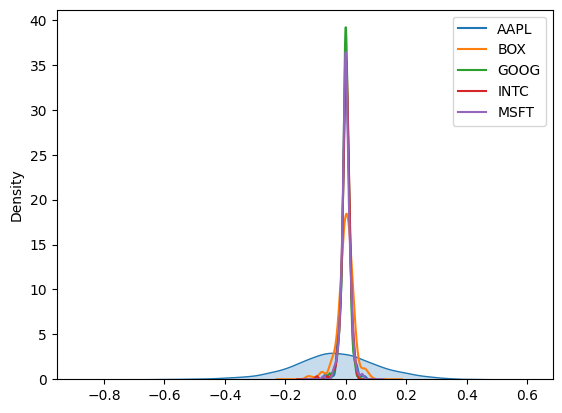

In [100]:
ret_data.plot(kind='density')
sns.kdeplot(simulated_returns.flatten(), label="Simulated Samples", shade=True)

<Axes: ylabel='Density'>

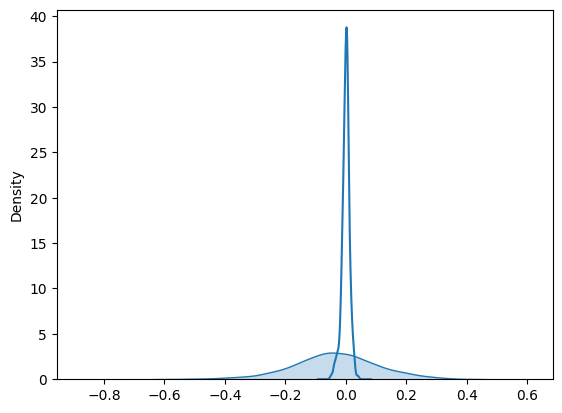

In [101]:
import seaborn as sns

sns.kdeplot(simulated_returns.flatten(), label="Simulated Samples", shade=True)
port_data['Portfolio.ret'].plot(kind='density')

In [102]:
def train(generator, discriminator, encoder, dataloader, num_epochs, device, criterion, optimizer_disc, optimizer_enc_gen, num_encoding):
    for epoch in range(num_epochs):
        for x_batch, in dataloader:
            x_batch = x_batch.to(device)

            # Discriminator
            optimizer_disc.zero_grad()
            z_real = encoder(x_batch)
            z_fake = torch.rand((x_batch.size(0), num_encoding)).to(device)
            gen_data = generator(z_fake)

            real_labels = torch.ones(x_batch.size(0), 1).to(device)
            fake_labels = torch.zeros(x_batch.size(0), 1).to(device)

            logits_real = discriminator(x_batch, z_real)
            logits_fake = discriminator(gen_data, z_fake)
            loss_real = criterion(logits_real, real_labels)
            loss_fake = criterion(logits_fake, fake_labels)
            d_loss = (loss_real + loss_fake) / 2

            d_loss.backward()
            optimizer_disc.step()

            # Encoder & Generator
            optimizer_enc_gen.zero_grad()

            z_real = encoder(x_batch)
            z_fake = torch.rand((x_batch.size(0), num_encoding)).to(device)
            gen_data = generator(z_fake)

            logits_real = discriminator(gen_data, z_fake)
            logits_fake = discriminator(x_batch, z_real)
            g_loss = criterion(logits_real, real_labels)
            e_loss = criterion(logits_fake, fake_labels)

            g_e_loss = g_loss + e_loss
            g_e_loss.backward()
            optimizer_enc_gen.step()

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] D Loss: {d_loss.item()} E Loss: {e_loss.item()} G Loss: {g_loss.item()}")


In [103]:
# Train the models
train(generator, discriminator, encoder, dataloader, num_epochs, device, criterion, optimizer_disc, optimizer_enc_gen, num_encoding)

# Generate samples after training
simulated_returns_trained = generate_samples(generator, 20000, device, num_encoding)
print(simulated_returns_trained)


Epoch [1000/4000] D Loss: 0.6926357746124268 E Loss: 0.6913341283798218 G Loss: 0.686490535736084
Epoch [2000/4000] D Loss: 0.6913421154022217 E Loss: 0.6970045566558838 G Loss: 0.6949781775474548
Epoch [3000/4000] D Loss: 0.6881033182144165 E Loss: 0.7026044130325317 G Loss: 0.6958701014518738
Epoch [4000/4000] D Loss: 0.6859371662139893 E Loss: 0.6876227259635925 G Loss: 0.7048178911209106
[[ 0.00336294  0.120791    0.11998031  0.09506467  0.12324096]
 [-0.07031186 -0.21062508 -0.07900399 -0.03234948 -0.09854783]
 [-0.01725234 -0.03031367 -0.04706255  0.00148193  0.05496275]
 ...
 [-0.09263192  0.10455848  0.05428687 -0.08715431  0.00680868]
 [-0.0526019   0.01483665 -0.02514293  0.06680461  0.05956656]
 [ 0.0647791   0.18254574  0.12008821  0.12295513  0.12380581]]


<Axes: ylabel='Density'>

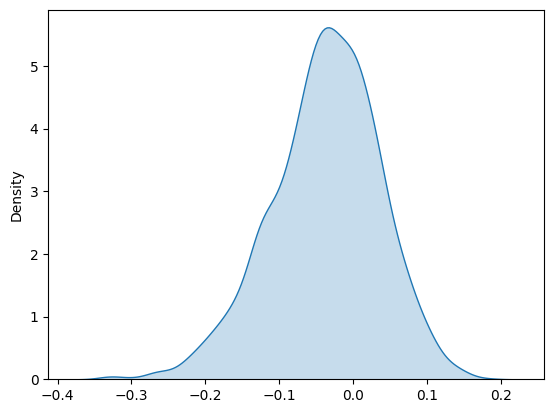

In [116]:
port_simulated_returns = np.dot(simulated_returns, weights)
sns.kdeplot(port_simulated_returns.flatten(), label="Simulated Samples", shade=True)

<Axes: ylabel='Density'>

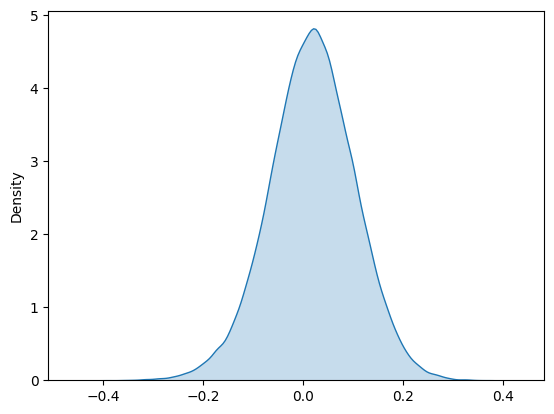

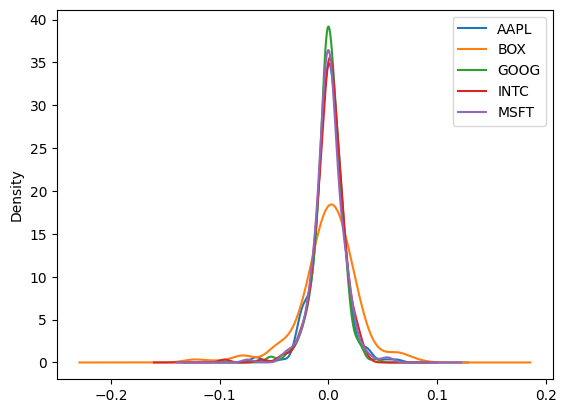

In [107]:
sns.kdeplot(simulated_returns_trained.flatten(), label="Simulated Samples", shade=True)

ret_data.plot(kind='density')

<Axes: ylabel='Density'>

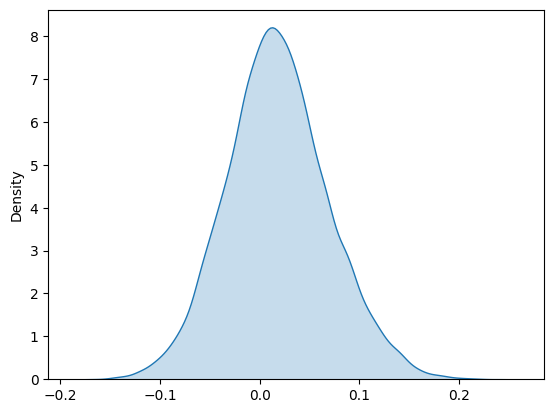

In [118]:
port_simulated_returns_trained=np.dot(simulated_returns_trained, weights)
sns.kdeplot(port_simulated_returns_trained.flatten(), label="Simulated Samples", shade=True)

<Axes: ylabel='Density'>

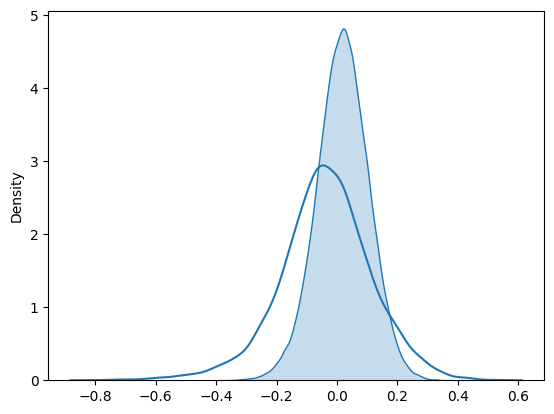

In [111]:
sns.kdeplot(simulated_returns_trained.flatten(), label="Simulated Samples", shade=True)
sns.kdeplot(simulated_returns.flatten(), label="Simulated Samples", shade=False)

In [117]:
calculate_var(port_simulated_returns)

0.11358070218563078

In [119]:
calculate_var(port_simulated_returns_trained)

0.14398993957042644